# Transformer 과제 

In [1]:
!pip install datasets transformers evaluate accelerate

The history saving thread hit an unexpected error (OperationalError('no such table: history')).History will not be written to the database.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: http://repo.ai.gato/registry/repository/pypi-proxy/simple
  Using cached http://repo.ai.gato/registry/repository/pypi-proxy/packages/fsspec/2024.9.0/fsspec-2024.9.0-py3-none-any.whl (179 kB)
  Using cached http://repo.ai.gato/registry/repository/pypi-proxy/packages/triton/3.2.0/triton-3.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (253.1 MB)
  Using cached http://repo.ai.gato/registry/repository/pypi-proxy/packages/sympy/1.13.1/sympy-1.13.1-py3-none-any.whl (6.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.12.0 requires numba-cuda<0.0.18,>=0.0.13, which is not installed.
s3fs 2025.2.0 requi

In [17]:
from datasets import load_dataset
from transformers import AutoTokenizer, EarlyStoppingCallback

# squad_kor_v1 dataset 

위 데이터셋은 KorQuAD(Korean Question Answering Dataset)의 첫번째 버전으로, 한국어 자연어 처리 연구에 중요한 역할을 하는 질문-응답 데이터 셋이다. 
- 데이터 구성

  train: 60,407

  valid: 5,774

- 데이터 형식
  id: 문자열 형태의 고유 식별자

  title: 문서 제목

  context: 지문 내용

  quenstion: 질문
  
  answers: 정답 텍스트와 시작 위치

- 특징

    질문에 대한 답이 항상 지문 안에 존재한다.

In [3]:
# 데이터셋 로드
dataset = load_dataset("squad_kor_v1")

In [4]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 60407
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5774
    })
})


In [6]:
dataset["train"][0]

{'id': '6566495-0-0',
 'title': '파우스트_서곡',
 'context': '1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.',
 'question': '바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?',
 'answers': {'text': ['교향곡'], 'answer_start': [54]}}

# BERT 모델을 선택한 이유 

- 문맥을 반영한 단어 표현이 가능하다
  bert는 단어를 문맥에 따라 다르게 이해하는 bidirectional 모델입니다. 
  해당 KorQuAD task의 질문과 지문은 문맥에 따라 동일한 단어라도 다른 의미로 쓰일 수 있습니다.

  예를 들면 ex) "서울은 한국의 수도이다" vs "서울에서 회의를 한다"에서 "서울"이 갖는 의미가
  다소 다른데, 이 점을 bert는 구분할 수 있다는 점을 생각하였습니다. 

- QA에 최적화된 구조
  질문에 대한 정답이 지문 내 특정 범위에 존재한다는 점을 생각해보았을 때, bert는 token-level classification이 가능하며, 질문과 지문을 함께 입력받아 정답의 start token과 end token을 예측하는 방식으로 쉽게 적용할 수 있을 것이라고 생각하였습니다. 

In [7]:
# 사용할 모델의 tokenizer 로드
model_name = "klue/bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 데이터 전처리 

아래 코드는 BERT 모델에 적합한 형태로 전처리 하는 함수입니다. 

- offset mapping
  토큰화된 텍스트의 각 토큰이 원본 텍스트에서 어디에 위치하는지를 나타내는 정보
  CLS, SEP 토큰 같은 경우 None으로 표시
  이는 Extraction-based Machine reading Comprehension task에서 모델의 예측을 원본 텍스트의 정확한 위치와 연결하는데 필수적이라고 함! 

In [8]:
# 전처리 함수 정의
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]] # 앞 뒤 공백 제거 
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True, # offset_mapping을 반환하여 원본 텍스트와 토큰의 위치를 매핑 
        padding="max_length", # 모든 입력을 최대 길이로 패딩 
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    # 각 예제에 대해 답변의 시작과 끝 위치를 문자 단위로 찾기 
    for i, offset in enumerate(offset_mapping): 
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = start_char + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # context의 start 및 end index 찾기
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # answer가 context 외부에 있는 경우
        if not (offset[context_start][0] <= start_char and offset[context_end][1] >= end_char):
            start_positions.append(0)
            end_positions.append(0)
        else:
            # answer의 start 및 end token 위치 결정
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    # 찾은 시작과 끝 위치를 inputs 딕셔너리에 추가, 반환 
    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs


In [13]:
# 데이터셋 전처리
tokenized_datasets = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset["train"].column_names,
)

# model load 

코사인 스케줄러 사용 

In [14]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

# 모델 로드
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="steps",
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    lr_scheduler_type="cosine",  # 코사인 스케줄러 사용
    warmup_ratio=0.1,  # Warm-up 비율 설정
)


/usr/gatoai/python/venv/3.10/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # 3 epoch 동안 성능 향상이 없으면 종료
)

/tmp/ipykernel_14763/2841158562.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# model train 

In [25]:
# 학습
trainer.train()

Step,Training Loss,Validation Loss
100,No log,5.611422
200,No log,4.142106
300,No log,1.514416
400,No log,0.923722
500,3.254000,0.752501
600,3.254000,0.679607
700,3.254000,0.638162
800,3.254000,0.582982
900,3.254000,0.573601
1000,0.726700,0.529153


TrainOutput(global_step=3300, training_loss=0.9677698216293797, metrics={'train_runtime': 3174.1732, 'train_samples_per_second': 57.092, 'train_steps_per_second': 3.569, 'total_flos': 1.03473515667456e+16, 'train_loss': 0.9677698216293797, 'epoch': 0.8739406779661016})

# model evaluation 

In [26]:
# 평가
trainer.evaluate()

{'eval_loss': 0.41589245200157166,
 'eval_runtime': 48.4192,
 'eval_samples_per_second': 119.25,
 'eval_steps_per_second': 7.456,
 'epoch': 0.8739406779661016}

# model test

평가 메트릭 
- F1 Score

  precision과 recall의 조화 평균으로 QA task에서는 예측된 답변과 실제 답변 사이의 단어 중복을 측정하게 됨

  0 ~ 1 사이의 값을 가지며, 부분적으로 정확한 답변에 대해서도 점수를 부여하므로 유연한 평가방법

- Exact Match

  모델의 예측이 정답과 정확히 일치하는 비율을 측정

  완벽히 일치하면 1, 그렇지 않으면 0점을 부여

두 메트릭 모두 a, an, the와 같은 관사와 구두점은 무시하고 계산됩니다. 

In [29]:
pip install evaluate

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: http://repo.ai.gato/registry/repository/pypi-proxy/simple
  Using cached http://repo.ai.gato/registry/repository/pypi-proxy/packages/fsspec/2024.9.0/fsspec-2024.9.0-py3-none-any.whl (179 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.12.0 requires numba-cuda<0.0.18,>=0.0.13, which is not installed.
s3fs 2025.2.0 requires fsspec==2025.2.0.*, but you have fsspec 2024.9.0 which is incompatible.
cudf-cu12 24.12.0 requires pyarrow<19.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 19.0.0 which is incompatible.
torch 2.6.0 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.13.3 which is incompatible.
torch 2.6.0 requires triton==3.2.0; platform_system == "Linux" and platform_machine == "x86_64", but you have triton 

In [34]:
import torch
import numpy as np
from datasets import load_dataset
from evaluate import load
from tqdm.auto import tqdm
import random

def test_model(model, tokenizer, n_samples=5):
    # 평가 지표 로드
    metric = load("squad")

    # Test set 로드 (KorQuAD는 공식 test set이 없어 validation set을 사용)
    test_dataset = load_dataset("squad_kor_v1", split="validation")

    # 예측 함수 정의
    def predict(examples):
        inputs = tokenizer(
            examples["question"],
            examples["context"],
            max_length=384,
            truncation="only_second",
            return_tensors="pt",
            padding="max_length",
        )
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        start_logits = outputs.start_logits
        end_logits = outputs.end_logits
        
        start_indices = torch.argmax(start_logits, dim=-1)
        end_indices = torch.argmax(end_logits, dim=-1)
        
        predictions = []
        for i in range(len(examples["question"])):
            start = start_indices[i].item()
            end = end_indices[i].item()
            pred = tokenizer.decode(inputs["input_ids"][i][start:end+1])
            predictions.append({"prediction_text": pred, "id": examples["id"][i]})
        
        return predictions

    # Test set에 대한 예측 수행
    all_predictions = []
    for i in tqdm(range(0, len(test_dataset), 32)):  # 배치 크기 32로 설정
        batch = test_dataset[i:i+32]
        predictions = predict(batch)
        all_predictions.extend(predictions)

    # 정답 데이터 준비
    references = [{"id": ex["id"], "answers": ex["answers"]} for ex in test_dataset]

    # 성능 평가
    result = metric.compute(predictions=all_predictions, references=references)

    print(f"\nTest set 성능:")
    print(f"F1 Score: {result['f1']:.2f}")
    print(f"Exact Match: {result['exact_match']:.2f}")

    # 샘플 예측 결과 출력
    print(f"\n{n_samples}개의 샘플 예측 결과:")
    samples = random.sample(range(len(test_dataset)), n_samples)
    for idx in samples:
        example = test_dataset[idx]
        prediction = next(pred for pred in all_predictions if pred["id"] == example["id"])
        
        print(f"\n질문: {example['question']}")
        print(f"컨텍스트: {example['context'][:100]}...")  # 컨텍스트의 처음 100자만 출력
        print(f"정답: {example['answers']['text'][0]}")
        print(f"예측: {prediction['prediction_text']}")

# 모델 테스트 실행
test_model(model, tokenizer)


  0%|          | 0/181 [00:00<?, ?it/s]


Test set 성능:
F1 Score: 85.36
Exact Match: 79.86

5개의 샘플 예측 결과:

질문: 제3지대가 반기문 총장을 옹립하여 새로운 당을 만드는 데 이사장으로서 노력하고 있다고 말한 사람은?
컨텍스트: 2015년 11월 친박계 홍문종 의원은 라디오에 출연하여 ‘반기문 대통령에 친박 총리 조합이 회자되고 있다’는 사회자의 질문에 “옳고 그르다를 떠나 가능성이 있는 이야기”라면서도 ...
정답: 정동춘
예측: 정동춘

질문: 공금횡령, 금품,향응수수를 행할 시 공직에서 완전 퇴출되는 제도는?
컨텍스트: 오세훈 시장은 ‘경쟁이 경쟁력’이라는 모토 아래 ‘신인사시스템’을 통해 청렴하고 능력 있는 사람은 연차에 상관없이 승진시키는 반면, 부패·무능공무원에 대해서는 ‘3%퇴출제’로 알려...
정답: 원스트라아크 아웃제
예측: 원스트라아크 아웃제

질문: 1996년 15대 총선에서 이명박이 출마한 지역구는?
컨텍스트: 1996년 4월 11일 치뤄진 15대 총선에서 이명박은 종로 지역구에 출마했다.정치신인이었던 이명박은 이종찬, 노무현 등 정치거물들과 건곤일척의 승부를 벌여 당선됐다. 그러나 이명...
정답: 종로
예측: 종로

질문: 명성황후가 1876년 맺은 조약은?
컨텍스트: 이에 긴장한 명성황후는 우호세력을 중용하여 세력을 강화한다. 1876년 강화도조약(조일수호조약)을 맺고 일련의 개화정책을 시행했다. 먼저 노론 계열이지만 개화사상가인 박규수(朴珪壽...
정답: 강화도조약
예측: 강화도조약

질문: 갤럭시 S7 엣지는 갤럭시 S6 엣지+의 어떤 기술까지 도입했나?
컨텍스트: 배터리 용량은 내장형 3600 mAh이다. 이는 디스플레이 크기를 키우면서 내부적으로 활용할 수 있는 공간이 늘었고 기기 두께도 상대적으로 두꺼워졌기 때문으로 전작인 갤럭시 S6 ...
정답: 고속 무선충전 기술
예측: 고속 무선충전 기술


# 분석 및 고찰 

학습 성
- 학습률과 early stopping 적용 전

    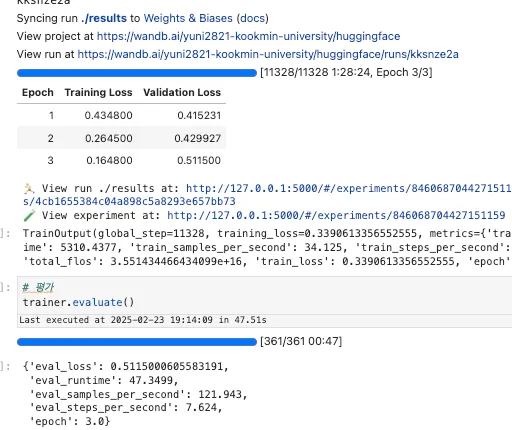
  
- 적용 후

    는 위와 같습니다.

  eval loss를 보면 성능이 더 좋아진 것을 알 수 있으며, early stopping으로 인해 더 빨리 학습이 종료될 수 있었습니다. 

- 평가 metric

  f1 score가 exact match보다 높은 것으로 보아 모델이 부분적으로 정확한 답변을 제공하는 경우가 있음을 나타내며 전반적으로 우수한 성능을 보임을 알 수 있었습니다. 

- 느낀점

  데이터 전처리 과정이 중요하다는 것을 알았습니다.
  처음 offset mapping을 적용하지 않고 학습을 한 결과 loss가 상당히 높았는데, 전처리 로직을 변경하니 현저히 낮은 loss가 나타나 NLP task에서 중요하게 바라보야하는 점이라고 생각하게 되었습니다.

